In [1]:
!pip install -q kagglehub

In [2]:
import os
import time
import itertools
import pathlib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import regularizers

In [3]:
import kagglehub

path = kagglehub.dataset_download(
    "tawsifurrahman/covid19-radiography-database"
)

print("Dataset root:", path)

100%|███████████████████████████████████████████████████████████████| 778M/778M [00:44<00:00, 18.3MB/s]

Extracting files...


Dataset root: /Users/vantiennguyen/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5


In [4]:
data_dir = os.path.join(path, "COVID-19_Radiography_Dataset")
print(os.listdir(data_dir))

['Lung_Opacity.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx', 'Viral Pneumonia', 'COVID.metadata.xlsx', 'Normal.metadata.xlsx', 'Lung_Opacity', 'Normal', 'COVID', 'README.md.txt']


In [5]:
def define_paths(data_dir):
    filepaths = []
    labels = []

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for sub in os.listdir(class_path):
            if sub.lower() == "masks":
                continue

            sub_path = os.path.join(class_path, sub)

            if os.path.isdir(sub_path):
                for img in os.listdir(sub_path):
                    filepaths.append(os.path.join(sub_path, img))
                    labels.append(class_name)
            else:
                filepaths.append(sub_path)
                labels.append(class_name)

    return filepaths, labels

In [6]:
def define_df(files, labels):
    return pd.DataFrame({
        "filepaths": files,
        "labels": labels
    })

In [7]:
def split_data(data_dir):
    files, labels = define_paths(data_dir)
    df = define_df(files, labels)

    train_df, temp_df = train_test_split(
        df, train_size=0.8, stratify=df["labels"], random_state=123
    )

    val_df, test_df = train_test_split(
        temp_df, train_size=0.5, stratify=temp_df["labels"], random_state=123
    )

    return train_df, val_df, test_df

In [8]:
train_df, val_df, test_df = split_data(data_dir)

print(len(train_df), len(val_df), len(test_df))

16932 2116 2117


In [9]:
def create_gens(train_df, val_df, test_df, batch_size):
    img_size = (224, 224)

    train_gen = ImageDataGenerator(horizontal_flip=True)
    valid_gen = ImageDataGenerator()
    test_gen  = ImageDataGenerator()

    train = train_gen.flow_from_dataframe(
        train_df,
        x_col="filepaths",
        y_col="labels",
        target_size=img_size,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=True
    )

    val = valid_gen.flow_from_dataframe(
        val_df,
        x_col="filepaths",
        y_col="labels",
        target_size=img_size,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=True
    )

    test = test_gen.flow_from_dataframe(
        test_df,
        x_col="filepaths",
        y_col="labels",
        target_size=img_size,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=False
    )

    return train, val, test

In [10]:
train_gen, val_gen, test_gen = create_gens(
    train_df, val_df, test_df, batch_size=16
)

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [11]:
class_count = len(train_gen.class_indices)
print("Classes:", train_gen.class_indices)

Classes: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [12]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3),
    pooling="max"
)

base_model.trainable = False

2026-01-20 14:41:40.136248: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2026-01-20 14:41:40.136416: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2026-01-20 14:41:40.136420: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2026-01-20 14:41:40.136582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-20 14:41:40.136592: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(
        256,
        activation="relu",
        kernel_regularizer=regularizers.l2(0.016),
        activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006)
    ),
    Dropout(0.45),
    Dense(class_count, activation="softmax")
])

In [14]:
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [15]:
EPOCHS = 15

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

Epoch 1/15


2026-01-20 14:41:42.382684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1059/1059 ━━━━━━━━━━━━━━━━━━━━ 105s 96ms/step - accuracy: 0.5518 - loss: 31.5261 - val_accuracy: 0.7481 - val_loss: 23.4357
Epoch 2/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 99s 94ms/step - accuracy: 0.5481 - loss: 13.6987 - val_accuracy: 0.5997 - val_loss: 7.1069
Epoch 3/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 102s 96ms/step - accuracy: 0.5977 - loss: 5.7584 - val_accuracy: 0.6725 - val_loss: 5.0359
Epoch 4/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 117s 110ms/step - accuracy: 0.6605 - loss: 4.9685 - val_accuracy: 0.8209 - val_loss: 4.6087
Epoch 5/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 118s 111ms/step - accuracy: 0.6892 - loss: 4.8128 - val_accuracy: 0.8417 - val_loss: 4.5146
Epoch 6/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 117s 110ms/step - accuracy: 0.6963 - loss: 4.7636 - val_accuracy: 0.8544 - val_loss: 4.5581
Epoch 7/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 132s 125ms/step - accuracy: 0.6998 - loss: 4.7341 - val_accuracy: 0.8563 - val_loss: 4.4938
Epoch 8/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 146s 138ms/step - accuracy: 0.69

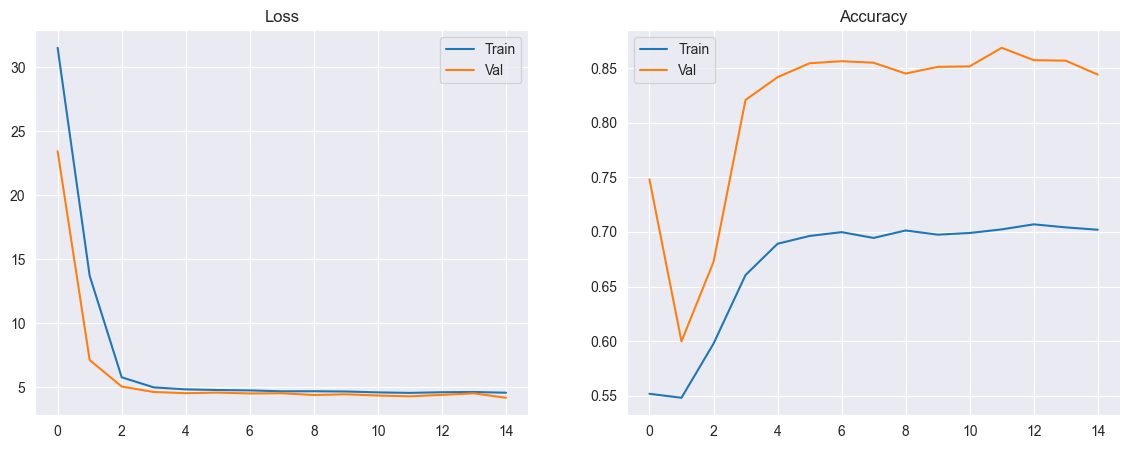

In [16]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.show()


In [17]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

133/133 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - accuracy: 0.8503 - loss: 4.1305
Test Accuracy: 0.8502597808837891


In [18]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

133/133 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step


In [19]:
cm = confusion_matrix(test_gen.classes, y_pred)
classes = list(test_gen.class_indices.keys())

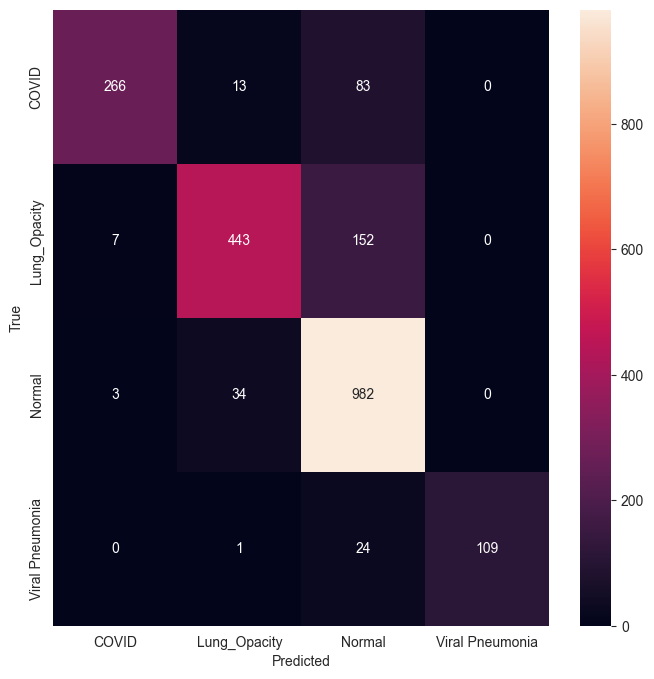

In [20]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [21]:
print(classification_report(
    test_gen.classes,
    y_pred,
    target_names=classes
))

                 precision    recall  f1-score   support

          COVID       0.96      0.73      0.83       362
   Lung_Opacity       0.90      0.74      0.81       602
         Normal       0.79      0.96      0.87      1019
Viral Pneumonia       1.00      0.81      0.90       134

       accuracy                           0.85      2117
      macro avg       0.91      0.81      0.85      2117
   weighted avg       0.87      0.85      0.85      2117



In [24]:
model.save("../backend/models/covid_efficientnetb0.keras")
print("Model saved")

Model saved
